In [1]:
import os
import sys

os.chdir("../..")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [3]:
# Import custom FFNN implementation
import os
import sys
# Add the parent directory to path to import your modules
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

from lib.neural import NeuralNetwork, NetworkLayer
from lib.ffnn import FFNN
from lib.activation import ReLU, Sigmoid, Tanh, Linear, Softmax
from lib.loss import MSE, BCE, CCE
from lib.weight_initializer import ZeroInitializer, UniformInitializer, NormalInitializer


INFO:root:Loading data


Sparsity with L1 penalty: 81.35%
Test score with L1 penalty: 0.8368
Example run in 5.253 s


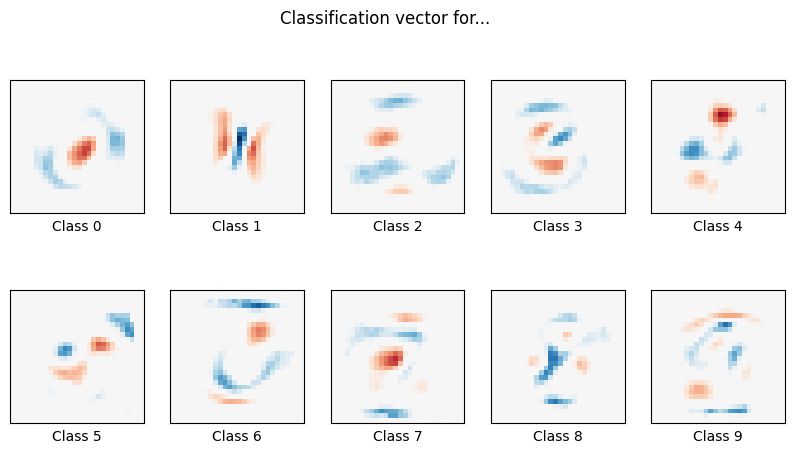

In [4]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
import logging

logging.basicConfig(level=logging.INFO)

# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
logging.info("Loading data")
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [5]:
# Preprocess data for FFNN
from sklearn.preprocessing import OneHotEncoder

# Load data (using your already loaded data)
# X_train and X_test are already loaded and scaled

# Convert labels to one-hot encoding for neural network
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Create validation set
X_train_ffnn, X_val, y_train_ffnn, y_val = train_test_split(
    X_train, y_train_onehot, test_size=0.2, random_state=42
)

print(f"Training set: {X_train_ffnn.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Input features: {X_train.shape[1]}")
print(f"Output classes: {y_train_onehot.shape[1]}")

Training set: 4000 samples
Validation set: 1000 samples
Test set: 10000 samples
Input features: 784
Output classes: 10


In [6]:
# Helper functions for evaluation and visualization
def evaluate_model(model, X, y_onehot):
    """Evaluate model accuracy on given data."""
    predictions = model.predict(X)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(y_onehot, axis=1)
    accuracy = np.mean(predicted_classes == true_classes)
    return accuracy

def plot_train_history(history, title="Training History"):
    """Plot training and validation loss history."""
    plt.figure(figsize=(10, 5))
    plt.plot(history['train_loss'], label='Training Loss')
    if 'val_loss' in history and history['val_loss']:
        plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

Testing width variations...

Width Variation 1: [784, 32, 10]


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s, loss=1.3860]

Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 930.43it/s, loss=5.1135]


Epoch 1/5 - 0.15s - loss: 5.1135 - val_loss: 2.8919


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 749.72it/s, loss=2.1705]


Epoch 2/5 - 0.18s - loss: 2.1705 - val_loss: 1.9001


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 701.85it/s, loss=1.4387]


Epoch 3/5 - 0.19s - loss: 1.4387 - val_loss: 1.4592


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 686.57it/s, loss=1.1034]


Epoch 4/5 - 0.20s - loss: 1.1034 - val_loss: 1.2033


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 564.21it/s, loss=0.9225]


Epoch 5/5 - 0.25s - loss: 0.9225 - val_loss: 1.0781
Test accuracy: 0.7322

Width Variation 2: [784, 128, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 100.53it/s, loss=9.4523]


Epoch 1/5 - 1.25s - loss: 9.4523 - val_loss: 4.5057


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 116.31it/s, loss=3.1580]


Epoch 2/5 - 1.08s - loss: 3.1580 - val_loss: 3.1685


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 110.05it/s, loss=2.0105]


Epoch 3/5 - 1.15s - loss: 2.0105 - val_loss: 2.5782


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 101.43it/s, loss=1.4858]


Epoch 4/5 - 1.25s - loss: 1.4858 - val_loss: 2.3122


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 102.07it/s, loss=1.2164]


Epoch 5/5 - 1.25s - loss: 1.2164 - val_loss: 2.1494
Test accuracy: 0.8015

Width Variation 3: [784, 512, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 78.87it/s, loss=12.8016]


Epoch 1/5 - 1.61s - loss: 12.8016 - val_loss: 7.0792


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 75.42it/s, loss=4.9370]


Epoch 2/5 - 1.68s - loss: 4.9370 - val_loss: 5.0665


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 92.44it/s, loss=3.3049]


Epoch 3/5 - 1.38s - loss: 3.3049 - val_loss: 4.2414


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 65.43it/s, loss=2.5645]


Epoch 4/5 - 1.96s - loss: 2.5645 - val_loss: 4.0305


Epoch 5/5: 100%|██████████| 125/125 [00:02<00:00, 53.00it/s, loss=2.1340]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Epoch 5/5 - 2.39s - loss: 2.1340 - val_loss: 3.8480
Test accuracy: 0.8183


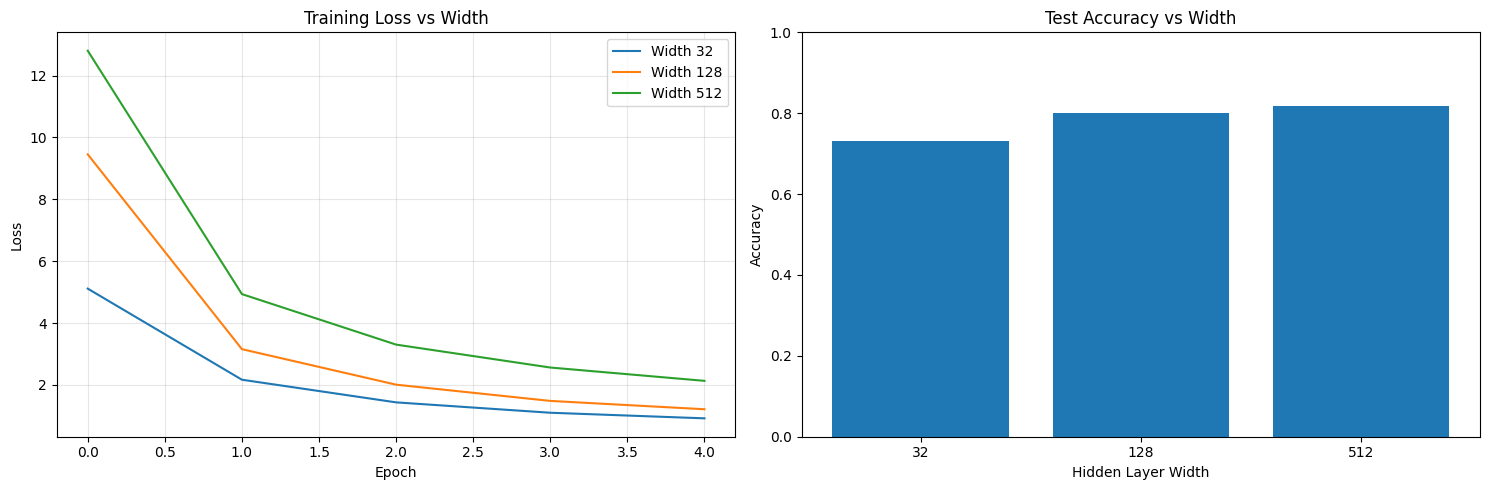


Testing depth variations...

Depth Variation 1: [784, 64, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 283.86it/s, loss=6.1565]


Epoch 1/5 - 0.46s - loss: 6.1565 - val_loss: 3.1320


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 256.10it/s, loss=2.3542]


Epoch 2/5 - 0.53s - loss: 2.3542 - val_loss: 2.1511


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 179.59it/s, loss=1.6408]


Epoch 3/5 - 0.73s - loss: 1.6408 - val_loss: 1.7551


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 218.83it/s, loss=1.2789]


Epoch 4/5 - 0.59s - loss: 1.2789 - val_loss: 1.5697


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 244.34it/s, loss=1.0375]


Epoch 5/5 - 0.56s - loss: 1.0375 - val_loss: 1.4509
Test accuracy: 0.7771

Depth Variation 2: [784, 64, 64, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 186.16it/s, loss=8.7357]


Epoch 1/5 - 0.71s - loss: 8.7357 - val_loss: 4.0758


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 216.09it/s, loss=2.6320]


Epoch 2/5 - 0.64s - loss: 2.6320 - val_loss: 2.7906


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 252.48it/s, loss=1.6908]


Epoch 3/5 - 0.52s - loss: 1.6908 - val_loss: 2.3696


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 232.50it/s, loss=1.2938]


Epoch 4/5 - 0.57s - loss: 1.2938 - val_loss: 2.0374


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 99.22it/s, loss=0.9968] 


Epoch 5/5 - 1.31s - loss: 0.9968 - val_loss: 1.8427
Test accuracy: 0.7579

Depth Variation 3: [784, 64, 64, 64, 10]


Epoch 1/5: 100%|██████████| 125/125 [00:00<00:00, 205.98it/s, loss=13.4205]


Epoch 1/5 - 0.66s - loss: 13.4205 - val_loss: 5.0661


Epoch 2/5: 100%|██████████| 125/125 [00:00<00:00, 181.62it/s, loss=3.6221]


Epoch 2/5 - 0.73s - loss: 3.6221 - val_loss: 2.9679


Epoch 3/5: 100%|██████████| 125/125 [00:00<00:00, 160.33it/s, loss=1.9103]


Epoch 3/5 - 0.84s - loss: 1.9103 - val_loss: 2.3097


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 280.17it/s, loss=1.2286]


Epoch 4/5 - 0.50s - loss: 1.2286 - val_loss: 1.9882


Epoch 5/5: 100%|██████████| 125/125 [00:00<00:00, 208.05it/s, loss=0.8490]
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Epoch 5/5 - 0.65s - loss: 0.8490 - val_loss: 1.9154
Test accuracy: 0.7392


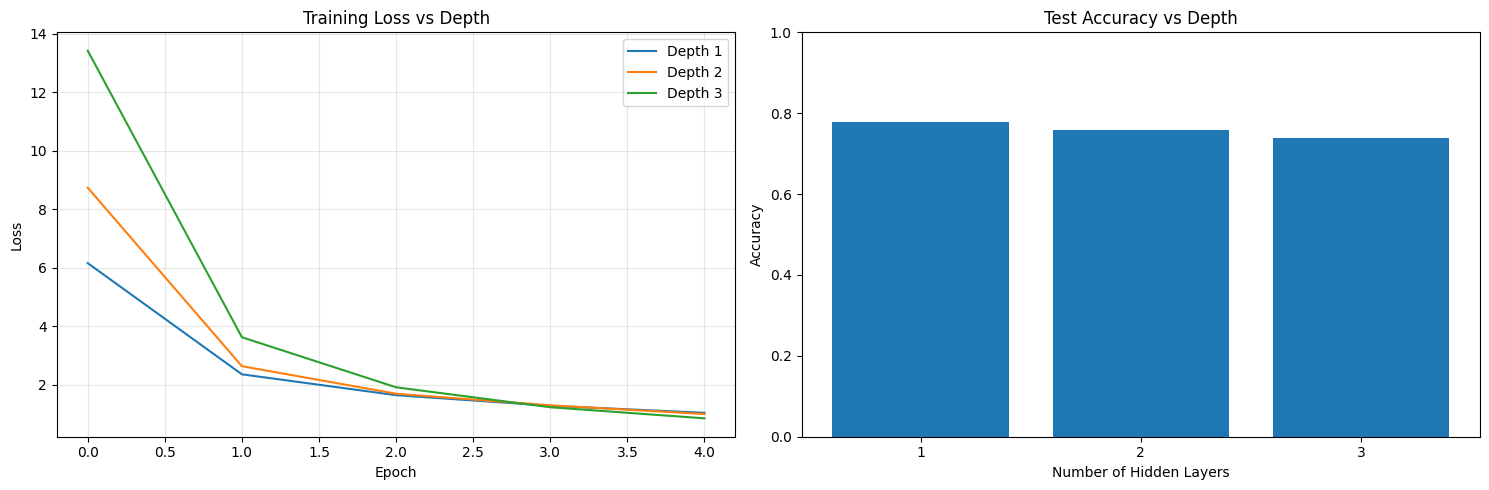

In [9]:
# Define base configuration
base_config = {
    'learning_rate': 0.32,
    'batch_size': 32,
    'epochs': 5,  # Using fewer epochs for faster testing
    'loss_function': CCE(),
    'activation': ReLU(),
    'initializer': NormalInitializer(seed=42)
}

# Define different architectures for width variation (fixed depth)
width_variations = [
    [784, 32, 10],         # Narrow
    [784, 128, 10],        # Medium
    [784, 512, 10]         # Wide
]

# Define different architectures for depth variation (fixed width)
depth_variations = [
    [784, 64, 10],               # Shallow (1 hidden layer)
    [784, 64, 64, 10],           # Medium (2 hidden layers)
    [784, 64, 64, 64, 10]        # Deep (3 hidden layers)
]

# Test width variations
width_histories = []
width_accuracies = []

print("Testing width variations...")
for i, architecture in enumerate(width_variations):
    print(f"\nWidth Variation {i+1}: {architecture}")
    
    # Create activations list (output layer uses Softmax)
    activations = [base_config['activation']] * (len(architecture) - 2) + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=[base_config['initializer']] * (len(architecture) - 1)
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=base_config['learning_rate'],
        verbose=1
    )
    
    # Store results
    width_histories.append(history)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    width_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot results for width variations
plt.figure(figsize=(15, 5))

# Plot width variation loss
plt.subplot(1, 2, 1)
for i, history in enumerate(width_histories):
    plt.plot(history['train_loss'], label=f"Width {width_variations[i][1]}")
plt.title('Training Loss vs Width')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare test accuracies for width
plt.subplot(1, 2, 2)
plt.bar([str(arch[1]) for arch in width_variations], width_accuracies)
plt.title('Test Accuracy vs Width')
plt.xlabel('Hidden Layer Width')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

# Test depth variations
depth_histories = []
depth_accuracies = []

print("\nTesting depth variations...")
for i, architecture in enumerate(depth_variations):
    print(f"\nDepth Variation {i+1}: {architecture}")
    
    # Create activations list (output layer uses Softmax)
    activations = [base_config['activation']] * (len(architecture) - 2) + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=[base_config['initializer']] * (len(architecture) - 1)
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=base_config['learning_rate'],
        verbose=1
    )
    
    # Store results
    depth_histories.append(history)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    depth_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot results for depth variations
plt.figure(figsize=(15, 5))

# Plot depth variation loss
plt.subplot(1, 2, 1)
for i, history in enumerate(depth_histories):
    plt.plot(history['train_loss'], label=f"Depth {len(depth_variations[i]) - 2}")
plt.title('Training Loss vs Depth')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Compare test accuracies for depth
plt.subplot(1, 2, 2)
plt.bar([str(len(arch) - 2) for arch in depth_variations], depth_accuracies)
plt.title('Test Accuracy vs Depth')
plt.xlabel('Number of Hidden Layers')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

Testing activation functions...

Activation: Linear


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 77.58it/s, loss=10.8820] 


Epoch 1/5 - 1.62s - loss: 10.8820 - val_loss: 5.3944


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 102.43it/s, loss=3.6966]


Epoch 2/5 - 1.25s - loss: 3.6966 - val_loss: 3.7869


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 109.35it/s, loss=2.5414]


Epoch 3/5 - 1.16s - loss: 2.5414 - val_loss: 3.3802


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 116.99it/s, loss=1.9794]


Epoch 4/5 - 1.08s - loss: 1.9794 - val_loss: 3.1737


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 102.23it/s, loss=1.6829]


Epoch 5/5 - 1.23s - loss: 1.6829 - val_loss: 3.1128
Test accuracy: 0.8263

Activation: ReLU


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 94.32it/s, loss=9.0855] 


Epoch 1/5 - 1.37s - loss: 9.0855 - val_loss: 4.5680


Epoch 2/5: 100%|██████████| 125/125 [00:02<00:00, 51.11it/s, loss=3.1802]


Epoch 2/5 - 2.47s - loss: 3.1802 - val_loss: 3.1984


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 99.89it/s, loss=2.0549]


Epoch 3/5 - 1.28s - loss: 2.0549 - val_loss: 2.6816


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 75.78it/s, loss=1.5338]


Epoch 4/5 - 1.67s - loss: 1.5338 - val_loss: 2.3373


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 108.44it/s, loss=1.2474]


Epoch 5/5 - 1.18s - loss: 1.2474 - val_loss: 2.2282
Test accuracy: 0.8022

Activation: Sigmoid


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 69.98it/s, loss=3.1229]


Epoch 1/5 - 1.81s - loss: 3.1229 - val_loss: 2.5164


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 94.02it/s, loss=2.2466]


Epoch 2/5 - 1.36s - loss: 2.2466 - val_loss: 2.0072


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 73.96it/s, loss=1.8019]


Epoch 3/5 - 1.71s - loss: 1.8019 - val_loss: 1.6726


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 84.76it/s, loss=1.5090]


Epoch 4/5 - 1.50s - loss: 1.5090 - val_loss: 1.4481


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 76.87it/s, loss=1.3058]


Epoch 5/5 - 1.65s - loss: 1.3058 - val_loss: 1.2909
Test accuracy: 0.5738

Activation: Tanh


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 75.24it/s, loss=4.1079]


Epoch 1/5 - 1.68s - loss: 4.1079 - val_loss: 2.9702


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 82.73it/s, loss=2.2918] 


Epoch 2/5 - 1.54s - loss: 2.2918 - val_loss: 2.0542


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 86.86it/s, loss=1.5876]


Epoch 3/5 - 1.47s - loss: 1.5876 - val_loss: 1.6429


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 90.43it/s, loss=1.2339] 


Epoch 4/5 - 1.40s - loss: 1.2339 - val_loss: 1.4194


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 87.00it/s, loss=1.0199] 


Epoch 5/5 - 1.46s - loss: 1.0199 - val_loss: 1.2796
Test accuracy: 0.6554


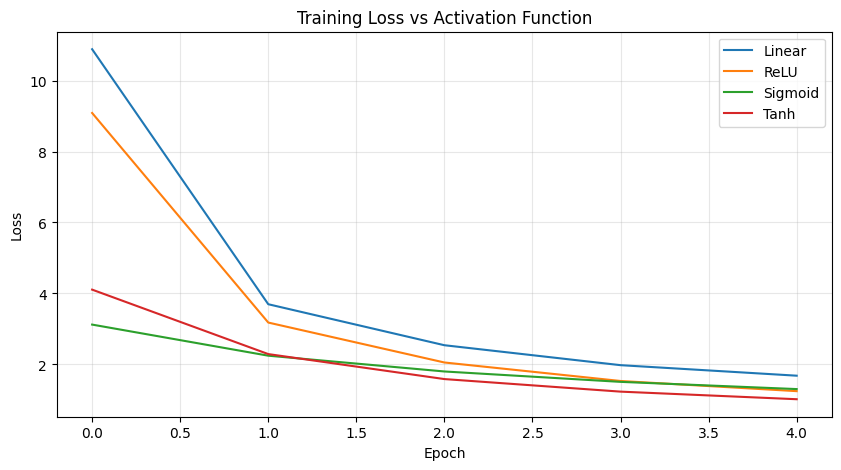

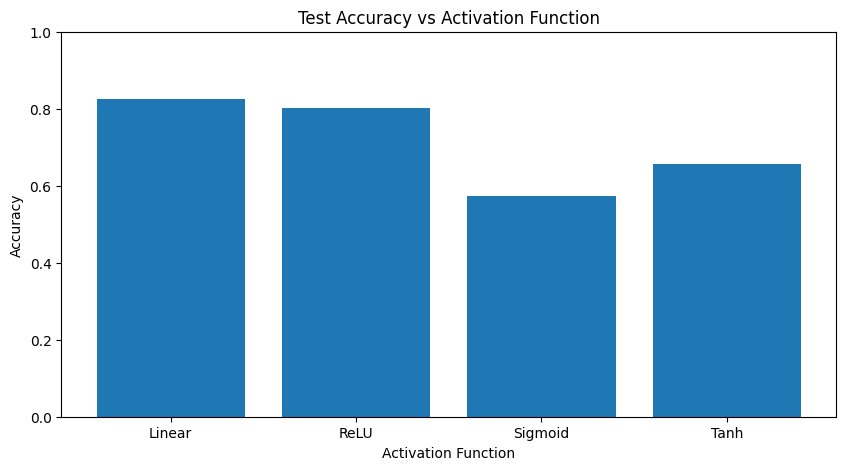

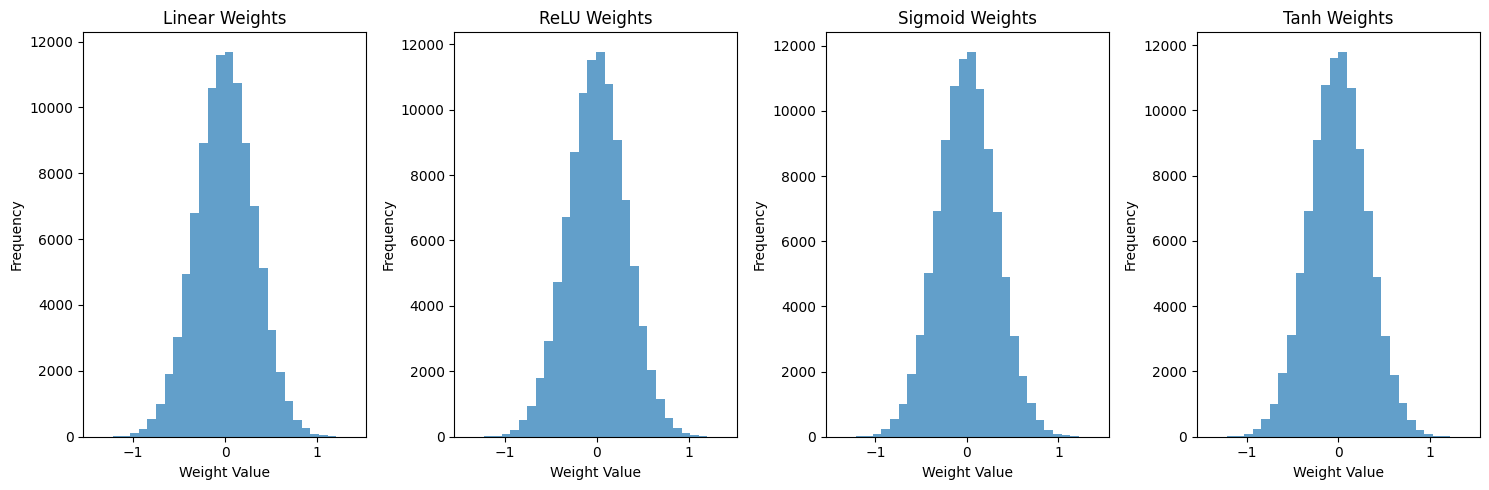

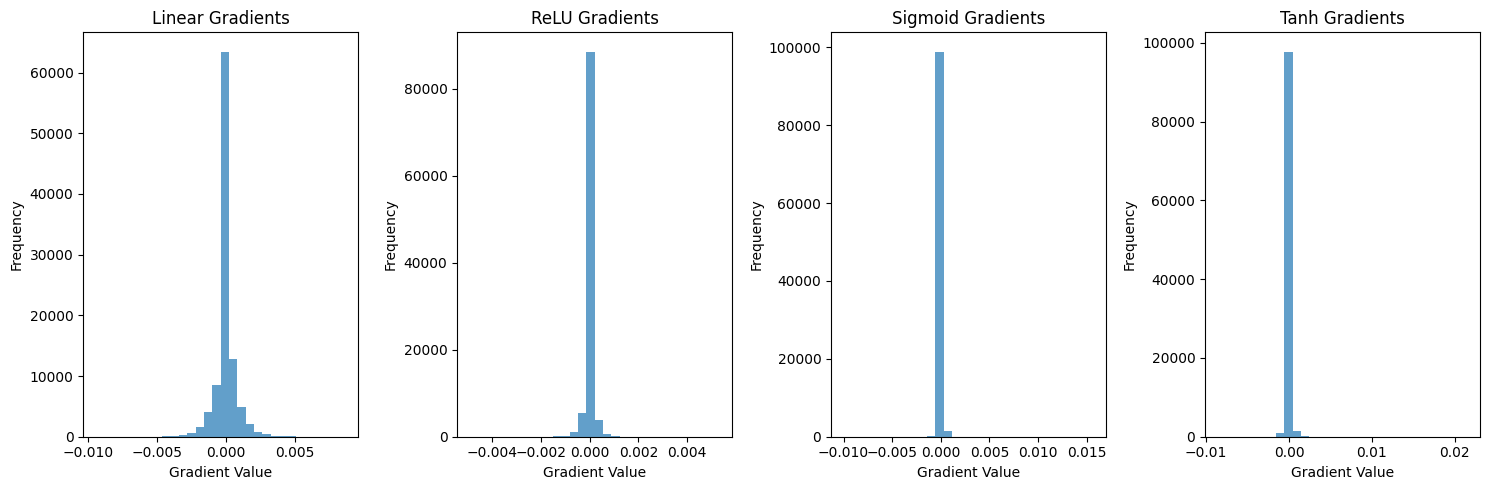

In [18]:
# Define base architecture
architecture = [784, 128, 10]

# Define activation functions to test (for hidden layers)
activation_functions = [Linear(), ReLU(), Sigmoid(), Tanh()]

# Test different activation functions
activation_histories = []
activation_accuracies = []
activation_models = []

print("Testing activation functions...")
for activation in activation_functions:
    print(f"\nActivation: {type(activation).__name__}")
    
    # Create activations list (output layer uses Softmax)
    activations = [activation] + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=[base_config['initializer']] * (len(architecture) - 1)
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        verbose=1, learning_rate=base_config['learning_rate']
    )
    
    # Store results
    activation_histories.append(history)
    activation_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    activation_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(activation_histories):
    plt.plot(history['train_loss'], label=f"{type(activation_functions[i]).__name__}")
plt.title('Training Loss vs Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar([type(act).__name__ for act in activation_functions], activation_accuracies)
plt.title('Test Accuracy vs Activation Function')
plt.xlabel('Activation Function')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(activation_models):
    plt.subplot(1, len(activation_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"{type(activation_functions[i]).__name__} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot gradient distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(activation_models):
    plt.subplot(1, len(activation_models), i+1)
    gradients = model.network.gradients[0].flatten()
    plt.hist(gradients, bins=30, alpha=0.7)
    plt.title(f"{type(activation_functions[i]).__name__} Gradients")
    plt.xlabel("Gradient Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Testing learning rates...

Learning Rate: 0.001


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 90.66it/s, loss=23.0095] 


Epoch 1/5 - 1.39s - loss: 23.0095 - val_loss: 22.3937


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 116.07it/s, loss=22.7741]


Epoch 2/5 - 1.09s - loss: 22.7741 - val_loss: 22.1720


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 94.10it/s, loss=22.5427]


Epoch 3/5 - 1.34s - loss: 22.5427 - val_loss: 21.9494


Epoch 4/5: 100%|██████████| 125/125 [00:00<00:00, 134.29it/s, loss=22.3140]


Epoch 4/5 - 0.95s - loss: 22.3140 - val_loss: 21.7292


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 116.73it/s, loss=22.0887]


Epoch 5/5 - 1.12s - loss: 22.0887 - val_loss: 21.5125
Test accuracy: 0.0949

Learning Rate: 0.01


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 108.16it/s, loss=22.0165]


Epoch 1/5 - 1.17s - loss: 22.0165 - val_loss: 20.4288


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 72.42it/s, loss=19.8828]


Epoch 2/5 - 1.74s - loss: 19.8828 - val_loss: 18.4912


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 112.52it/s, loss=17.9904]


Epoch 3/5 - 1.12s - loss: 17.9904 - val_loss: 16.8300


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 111.87it/s, loss=16.3773]


Epoch 4/5 - 1.14s - loss: 16.3773 - val_loss: 15.4478


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 82.11it/s, loss=14.9758] 


Epoch 5/5 - 1.55s - loss: 14.9758 - val_loss: 14.2025
Test accuracy: 0.2266

Learning Rate: 0.1


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 111.34it/s, loss=15.3175]


Epoch 1/5 - 1.14s - loss: 15.3175 - val_loss: 9.7819


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 103.77it/s, loss=7.3723]


Epoch 2/5 - 1.24s - loss: 7.3723 - val_loss: 6.2134


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 104.18it/s, loss=4.8445]


Epoch 3/5 - 1.22s - loss: 4.8445 - val_loss: 4.8535


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 68.11it/s, loss=3.7060]


Epoch 4/5 - 1.85s - loss: 3.7060 - val_loss: 4.1187


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 67.80it/s, loss=3.0748]


Epoch 5/5 - 1.88s - loss: 3.0748 - val_loss: 3.6841
Test accuracy: 0.6954


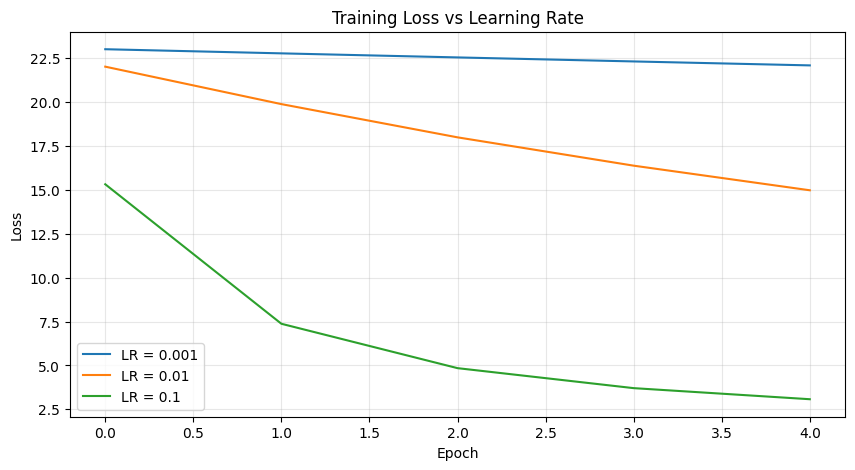

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


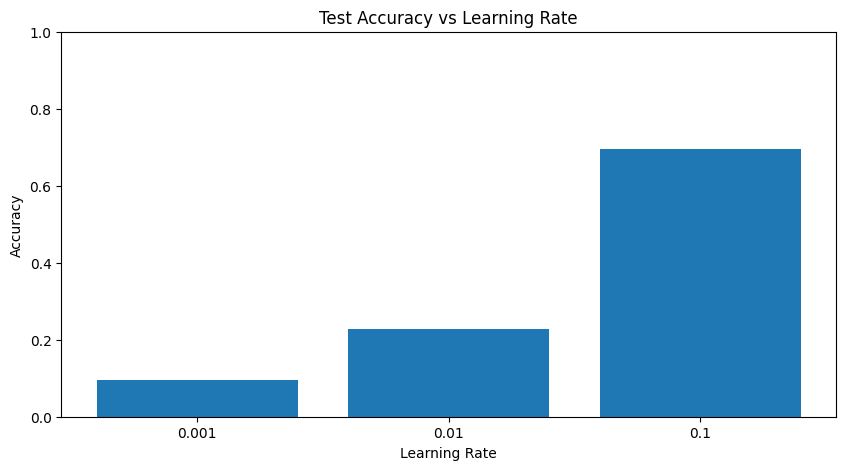

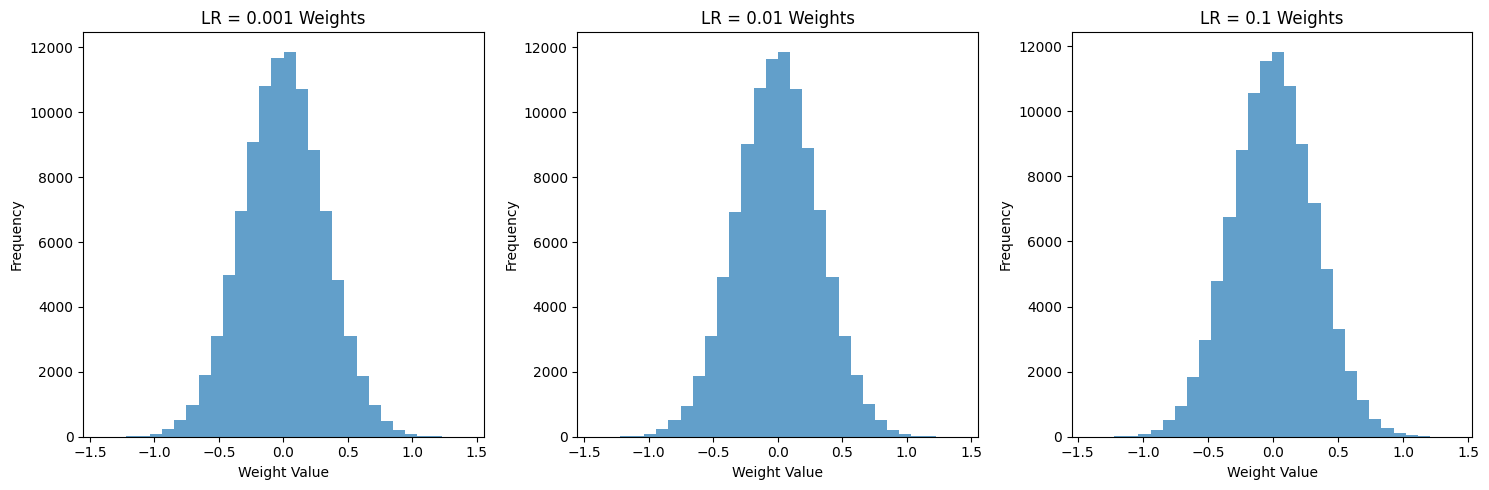

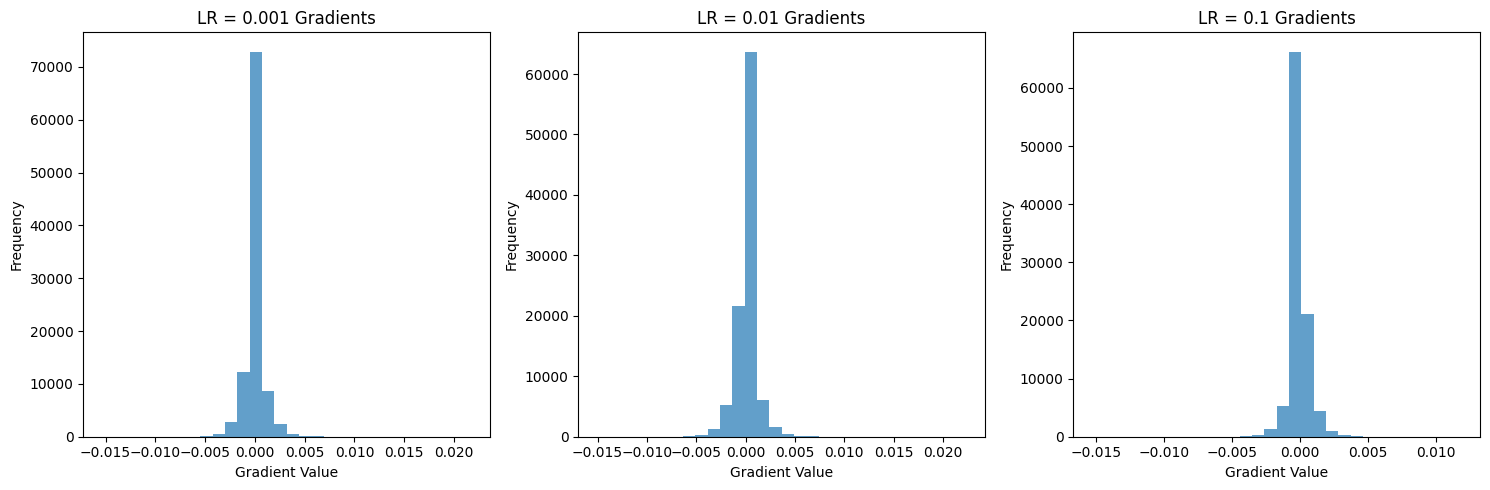

In [20]:
# Define base architecture
architecture = [784, 128, 10]

# Define learning rates to test
learning_rates = [0.001, 0.01, 0.1]

# Test different learning rates
lr_histories = []
lr_accuracies = []
lr_models = []

print("Testing learning rates...")
for lr in learning_rates:
    print(f"\nLearning Rate: {lr}")
    
    # Create activations list (output layer uses Softmax)
    activations = [ReLU()] + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=base_config['initializer']
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        learning_rate=lr,
        verbose=1
    )
    
    # Store results
    lr_histories.append(history)
    lr_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    lr_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(lr_histories):
    plt.plot(history['train_loss'], label=f"LR = {learning_rates[i]}")
plt.title('Training Loss vs Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar([str(lr) for lr in learning_rates], lr_accuracies)
plt.title('Test Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(lr_models):
    plt.subplot(1, len(lr_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"LR = {learning_rates[i]} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot gradient distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(lr_models):
    plt.subplot(1, len(lr_models), i+1)
    gradients = model.network.gradients[0].flatten()
    plt.hist(gradients, bins=30, alpha=0.7)
    plt.title(f"LR = {learning_rates[i]} Gradients")
    plt.xlabel("Gradient Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Testing weight initializers...

Initializer: Zero


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 103.83it/s, loss=2.3024]


Epoch 1/5 - 1.21s - loss: 2.3024 - val_loss: 2.3022


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 80.91it/s, loss=2.3018]


Epoch 2/5 - 1.57s - loss: 2.3018 - val_loss: 2.3019


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 113.78it/s, loss=2.3013]


Epoch 3/5 - 1.12s - loss: 2.3013 - val_loss: 2.3017


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 123.49it/s, loss=2.3009]


Epoch 4/5 - 1.03s - loss: 2.3009 - val_loss: 2.3015


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 99.05it/s, loss=2.3007] 


Epoch 5/5 - 1.28s - loss: 2.3007 - val_loss: 2.3015
Test accuracy: 0.1139

Initializer: Uniform


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 97.69it/s, loss=1.5838] 


Epoch 1/5 - 1.30s - loss: 1.5838 - val_loss: 1.0812


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 97.70it/s, loss=0.8418]


Epoch 2/5 - 1.29s - loss: 0.8418 - val_loss: 0.7320


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 78.93it/s, loss=0.5914]


Epoch 3/5 - 1.60s - loss: 0.5914 - val_loss: 0.5827


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 83.88it/s, loss=0.4688]


Epoch 4/5 - 1.51s - loss: 0.4688 - val_loss: 0.5072


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 66.52it/s, loss=0.3961]


Epoch 5/5 - 1.91s - loss: 0.3961 - val_loss: 0.4568
Test accuracy: 0.8706

Initializer: Normal


Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 88.01it/s, loss=9.3037]


Epoch 1/5 - 1.43s - loss: 9.3037 - val_loss: 4.6783


Epoch 2/5: 100%|██████████| 125/125 [00:02<00:00, 59.44it/s, loss=3.2296] 


Epoch 2/5 - 2.13s - loss: 3.2296 - val_loss: 3.1380


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 69.86it/s, loss=2.0614]


Epoch 3/5 - 1.81s - loss: 2.0614 - val_loss: 2.5924


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 89.27it/s, loss=1.5426]


Epoch 4/5 - 1.42s - loss: 1.5426 - val_loss: 2.3728


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 76.07it/s, loss=1.2421]


Epoch 5/5 - 1.66s - loss: 1.2421 - val_loss: 2.2004
Test accuracy: 0.8004


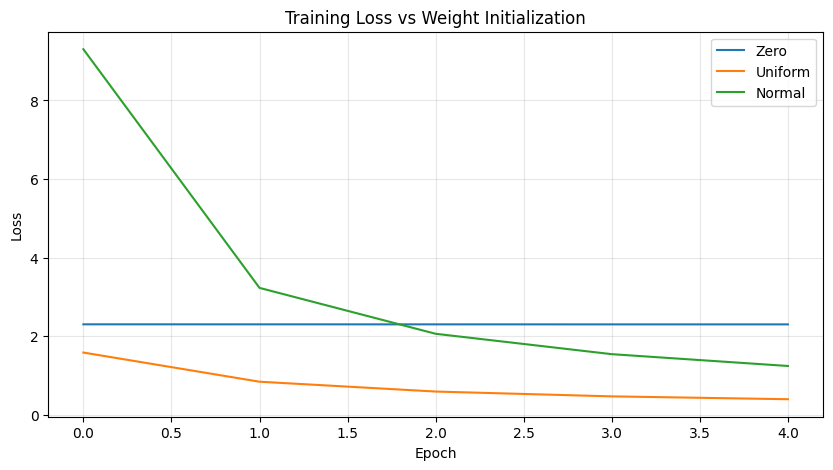

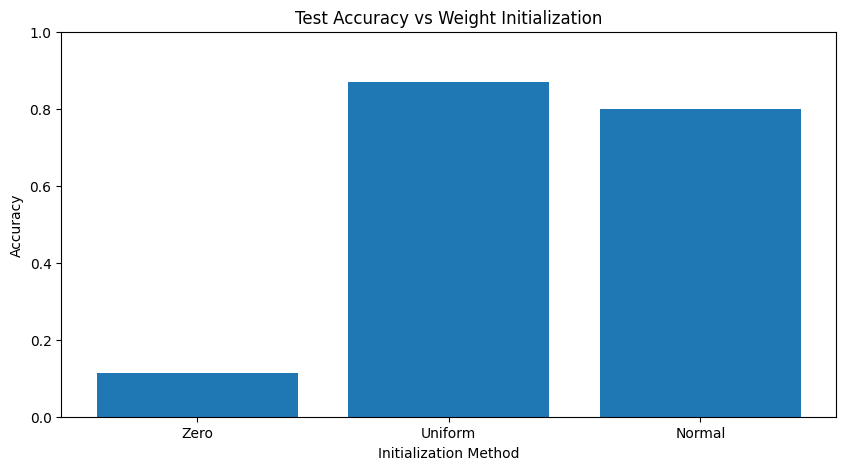

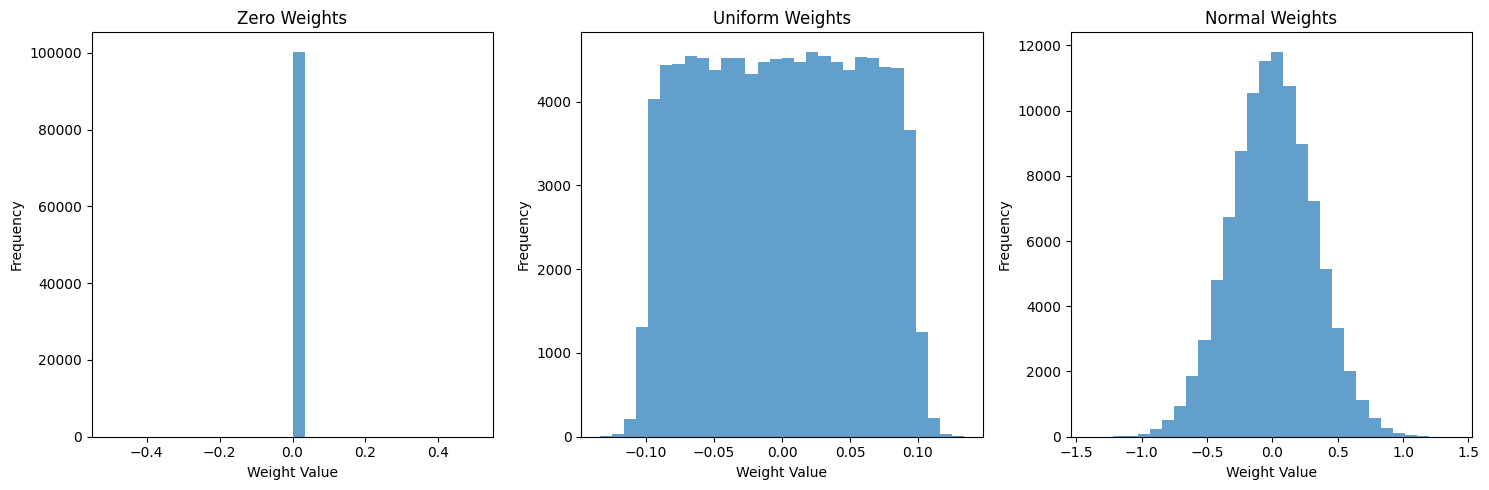

In [21]:
# Define base architecture
architecture = [784, 128, 10]

# Define initializers to test
initializers = [
    ZeroInitializer(),
    UniformInitializer(low=-0.1, high=0.1, seed=42),
    NormalInitializer(mean=0, var=0.1, seed=42)
]
initializer_names = ["Zero", "Uniform", "Normal"]

# Test different initializers
init_histories = []
init_accuracies = []
init_models = []

print("Testing weight initializers...")
for i, initializer in enumerate(initializers):
    print(f"\nInitializer: {initializer_names[i]}")
    
    # Create activations list (output layer uses Softmax)
    activations = [ReLU()] + [Softmax()]
    
    # Create neural network
    network = NeuralNetwork(
        node_counts=architecture,
        activations=activations,
        loss_function=base_config['loss_function'],
        initialize_methods=initializer
    )
    
    # Create FFNN model
    model = FFNN(network)
    
    # Train the model
    history = model.fit(
        X_train_ffnn, y_train_ffnn,
        batch_size=base_config['batch_size'],
        epochs=base_config['epochs'],
        validation_data=(X_val, y_val),
        verbose=1, learning_rate=base_config['learning_rate']
    )
    
    # Store results
    init_histories.append(history)
    init_models.append(model)
    
    # Evaluate on test set
    accuracy = evaluate_model(model, X_test, y_test_onehot)
    init_accuracies.append(accuracy)
    print(f"Test accuracy: {accuracy:.4f}")

# Plot training loss
plt.figure(figsize=(10, 5))
for i, history in enumerate(init_histories):
    plt.plot(history['train_loss'], label=f"{initializer_names[i]}")
plt.title('Training Loss vs Weight Initialization')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Compare test accuracies
plt.figure(figsize=(10, 5))
plt.bar(initializer_names, init_accuracies)
plt.title('Test Accuracy vs Weight Initialization')
plt.xlabel('Initialization Method')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

# Plot initial weight distributions
plt.figure(figsize=(15, 5))
for i, model in enumerate(init_models):
    plt.subplot(1, len(init_models), i+1)
    weights = model.network.weights[0].flatten()
    plt.hist(weights, bins=30, alpha=0.7)
    plt.title(f"{initializer_names[i]} Weights")
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Training custom FFNN model...


Epoch 1/5:   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1/5: 100%|██████████| 125/125 [00:01<00:00, 84.02it/s, loss=9.1065] 


Epoch 1/5 - 1.50s - loss: 9.1065 - val_loss: 4.5911


Epoch 2/5: 100%|██████████| 125/125 [00:01<00:00, 118.97it/s, loss=3.1392]


Epoch 2/5 - 1.07s - loss: 3.1392 - val_loss: 3.1876


Epoch 3/5: 100%|██████████| 125/125 [00:01<00:00, 110.23it/s, loss=2.0657]


Epoch 3/5 - 1.15s - loss: 2.0657 - val_loss: 2.6302


Epoch 4/5: 100%|██████████| 125/125 [00:01<00:00, 118.68it/s, loss=1.5448]


Epoch 4/5 - 1.09s - loss: 1.5448 - val_loss: 2.3305


Epoch 5/5: 100%|██████████| 125/125 [00:01<00:00, 97.45it/s, loss=1.2418] 


Epoch 5/5 - 1.32s - loss: 1.2418 - val_loss: 2.1650

Training sklearn MLPClassifier...
First few training labels: [2 8 7 3 9]
Label type: <class 'numpy.ndarray'> int64
Iteration 1, loss = 0.57468045
Iteration 2, loss = 0.17455098
Iteration 3, loss = 0.10187562
Iteration 4, loss = 0.06257427
Iteration 5, loss = 0.04260281

Model Comparison:
Custom FFNN accuracy: 0.8032
sklearn MLP accuracy: 0.9259


/home/ganadipa/code/kuliah/sem6/Machine-learning/tubes-1/.venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(


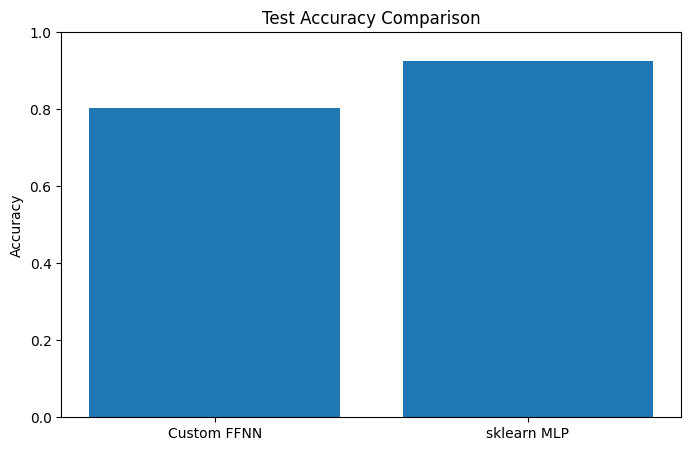

In [26]:
# Import sklearn's MLPClassifier
from sklearn.neural_network import MLPClassifier

# Define architecture and parameters
architecture = [784, 128, 10]
learning_rate = 0.32
batch_size = 32
epochs = 5

# Create our custom FFNN
activations = [ReLU()] + [Softmax()]
network = NeuralNetwork(
    node_counts=architecture,
    activations=activations,
    loss_function=CCE(),
    initialize_methods=NormalInitializer(seed=42)
)
custom_model = FFNN(network)

# Train our custom model
print("Training custom FFNN model...")
custom_history = custom_model.fit(
    X_train_ffnn, y_train_ffnn,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    verbose=1, learning_rate=learning_rate
)

# Create sklearn MLPClassifier
sklearn_model = MLPClassifier(
    hidden_layer_sizes=(128,),
    activation='relu',
    solver='sgd',
    alpha=0.0001,
    batch_size=batch_size,
    learning_rate_init=0.01,
    max_iter=epochs,
    random_state=42,
    verbose=True
)

# Train sklearn model with correct target format
print("\nTraining sklearn MLPClassifier...")
# Convert string labels to integers if needed
y_train_int = np.array(y_train).astype(int) if isinstance(y_train[0], str) else np.array(y_train, dtype=int)
y_test_int = np.array(y_test).astype(int) if isinstance(y_test[0], str) else np.array(y_test, dtype=int)

# Check first few labels to debug
print(f"First few training labels: {y_train_int[:5]}")
print(f"Label type: {type(y_train_int)} {y_train_int.dtype}")

# Fit the model
sklearn_model.fit(X_train, y_train_int)

# Evaluate both models
custom_accuracy = evaluate_model(custom_model, X_test, y_test_onehot)
sklearn_predictions = sklearn_model.predict(X_test)
sklearn_accuracy = np.mean(sklearn_predictions == y_test_int)

print("\nModel Comparison:")
print(f"Custom FFNN accuracy: {custom_accuracy:.4f}")
print(f"sklearn MLP accuracy: {sklearn_accuracy:.4f}")

# Compare accuracies
plt.figure(figsize=(8, 5))
plt.bar(['Custom FFNN', 'sklearn MLP'], [custom_accuracy, sklearn_accuracy])
plt.title('Test Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()